In [14]:
#Librarys: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
import latex
from cycler import cycler
import time

import matplotlib.pyplot as plt 
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": "15",
    "font.serif": ["Times New Roman"]})
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('legend', fontsize=11) 
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from palettable.colorbrewer.qualitative import Set1_5

In [15]:
def mean_number_photons(delta,input_list,times,psi0):

    """
    This function handles the time evolution and returns the mean number 
    of photons for each value of detuning.
    """
    
    Nat = input_list[0]
    N = input_list[1] 
    kappa = input_list[2]
    g = input_list[3]
    EM = input_list[4]
    Oc = input_list[5]
    norm = input_list[6]
    
    G31 = input_list[7]
    G32 = input_list[8]
    D1 = input_list[9]
    D2 = input_list[10]
    
    
    
    #atomic operators
    S11_list = []
    S22_list = []
    S33_list = []
    S13_list = []
    S23_list = []
    
    for n in range(Nat):
        op_list = []
        for m in range(Nat+1):
            op_list.append(qeye(3))

        op_list[0] = qeye(N)
        
        op_list[n+1] = basis(3,0)*basis(3,0).dag()
        S11_list.append(tensor(op_list))

        op_list[n+1] = basis(3,1)*basis(3,1).dag()
        S22_list.append(tensor(op_list))

        op_list[n+1] = basis(3,2)*basis(3,2).dag()
        S33_list.append(tensor(op_list))
        
        op_list[n+1] = basis(3,0)*basis(3,2).dag()
        S13_list.append(tensor(op_list))
        
        op_list[n+1] = basis(3,1)*basis(3,2).dag()
        S23_list.append(tensor(op_list))        
       
    #total atomic operators
    S11 = 0
    S22 = 0
    S33 = 0
    S13 = 0
    S23 = 0
    
    for n in range(Nat):
        S11 = S11 + S11_list[n]
        S22 = S22 + S22_list[n]
        S33 = S33 + S33_list[n]
        S13 = S13 + S13_list[n]
        S23 = S23 + S23_list[n]

    #colapse Operators
    C = np.sqrt(kappa)*a   #cavity  
    C31_list = []
    C32_list = []
    
    for n in range(Nat):
        C31_list.append(np.sqrt(G31)*S13_list[n])
        C32_list.append(np.sqrt(G32)*S23_list[n])
    
    Clist = [C] + C31_list + C32_list

    Ht = D1*S33 + (D1-D2)*S22 + delta*S11 - delta*a.dag()*a + (g*a*S13.dag() + Oc*S23.dag() + EM*a + g*a.dag()*S13 + Oc*S23 + EM*a.dag())
        

    # master equation solver
    #data = mesolve(Ht, psi0, times, Clist, [a.dag() * a])
    #nm_at = data.expect[0]/norm
    #nm_a = np.mean(nm_at[-100:])
        
    # monte carlo solver
    #opt = Options(ntraj=1,num_cpus=8)
    #Options = [ntrajint==1,num_cpus==8]
    #data = mcsolve(Ht, psi0, times, Clist, [a.dag() * a], progress_bar=False,ntraj=6)#,num_cpus=8)# options=opt)
    #nm_at = data.expect[0]/norm
    #nm_a = np.mean(nm_at[-100:])
    
    #print("%f,%f" %(delta,nm_a)) 

    #steady state method (demands a high amount of memory as we increase the system's dimension)
    rho_a = steadystate(Ht, Clist, method='direct', use_precond=False, use_rcm=True, maxiter=1000, tol=1e-12)
    nm_a = expect(a.dag()*a, rho_a)/norm  # expectation value of nm -> normalized

    return nm_a

In [17]:
if __name__ == '__main__':   
    
    ini = time.time() #starts counting time
    print(time.ctime()) #print initial time
    kappa = 1.0 #cavity mode dissipation rate (this is why the parameters should be passed as arguments to the function func1)
    Oc = 1.0*kappa #Rabi frequency 
    delta = kappa   # Delta_P
    Nat = 1    
    N = 6 #Fock space dimension
    g_list = np.linspace(0.1, 20,100)#/np.sqrt(Nat))*kappa # List atom-field coupling strenght
    index_j = range(0,len(g_list)) #length of the parameter list
    EM = np.sqrt(0.01)*kappa #pump field strength
    norm = 4*(EM/(kappa))**2 #normalization
    #decay rates
    G31 = 0.5*kappa  #atom
    G32 = 0.5*kappa  #atom
    #detunings
    D1 = 0.0
    D2 = 0.0
    #D2 = kappa
        
    times = np.linspace(0.0, 2100, 1050) #evolution time list
    aux_list = []
    for m in range(Nat+1):
        aux_list.append(basis(3,1))
    aux_list[0] = basis(N,0)
    psi0 = tensor(aux_list)

    #Projectors (N,n,m) = ket(n)*bra(m) - probability to measure m in the state n: : 

    P1 = 1*tensor(projection(N, 1, 1, offset=None), qeye(2))
    P2 = 1*tensor(projection(N, 2, 2, offset=None), qeye(2))
    P3 = 1*tensor(projection(N, 3, 3, offset=None), qeye(2))
    P4 = 1*tensor(projection(N, 4, 4, offset=None), qeye(2))

    # Operadores do campo: 
    
    op_list = []
    sm_list = []
    sz_list = []
    for m in range(Nat+1):
        op_list.append(qeye(3))
        sm_list.append(sigmam())
        sz_list.append(sigmaz())
    op_list[0] = destroy(N)
    sz_list[0] = qeye(N)
    sm_list[0] = qeye(N)
    a = tensor(op_list)    #muda conforme o numero de atomos
    sm = tensor(sm_list)   #'sigma_-'(sigmam is annihilation operator for Pauli spins)
    sz = tensor(sz_list)   #sigmaz is Pauli spin 1/2 z matrix
    
    # Create empty lists to store the projections
    np_list = []      #Mean number of photon inside the cavity
    n2_list = []      #to calculate g2
    na_list = []      #Mean number of occupation in excited state
    g20_list = []     #Second-order correlation function 
    P_1_list = []
    P_2_list = []
    P_3_list = []
    rho_list = []

    # Primeiro Loop: cálculo de rho
    
    for j in index_j:
        
        g = g_list[j]      
        #print('g',g)

        input_list = [Nat,N,kappa,g,EM,Oc,norm,G31,G32,D1,D2]

        rho_list.append(mean_number_photons(delta, input_list, times, psi0))
        
    # Segundo Loop: cálculo das projeções    
    print(a[0], a.dag()[0],rho_list[0])
    for rho in rho_list:

        np = expect(a.dag()*a, rho)
        np_list.append(np)
        n2 = expect((a.dag()**2)*(a**2), rho)
        n2_list.append(n2)
        na_list.append(expect(sm.dag()*sm, rho))
        g20_list.append(n2/np**2)
        
        P_1_list.append(expect(P1, rho))
        P_2_list.append(expect(P2, rho))
        P_3_list.append(expect(P3, rho))
        

       
        #fin = time.time() 
        #print("%f,%f,%d,%.2f" % (g,width_a,j,(fin-ini)/3600))

    #output_data = np.vstack((g_list, Wa))   # join Oc and expt data
    #file_data_store('FWHMxg_Nat1_ep1_test.csv', output_data.T, numtype="real", numformat="decimal", sep= ",") 


Fri May 10 14:55:07 2024
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j] 0.19689671338805614


TypeError: Arguments must be quantum objects

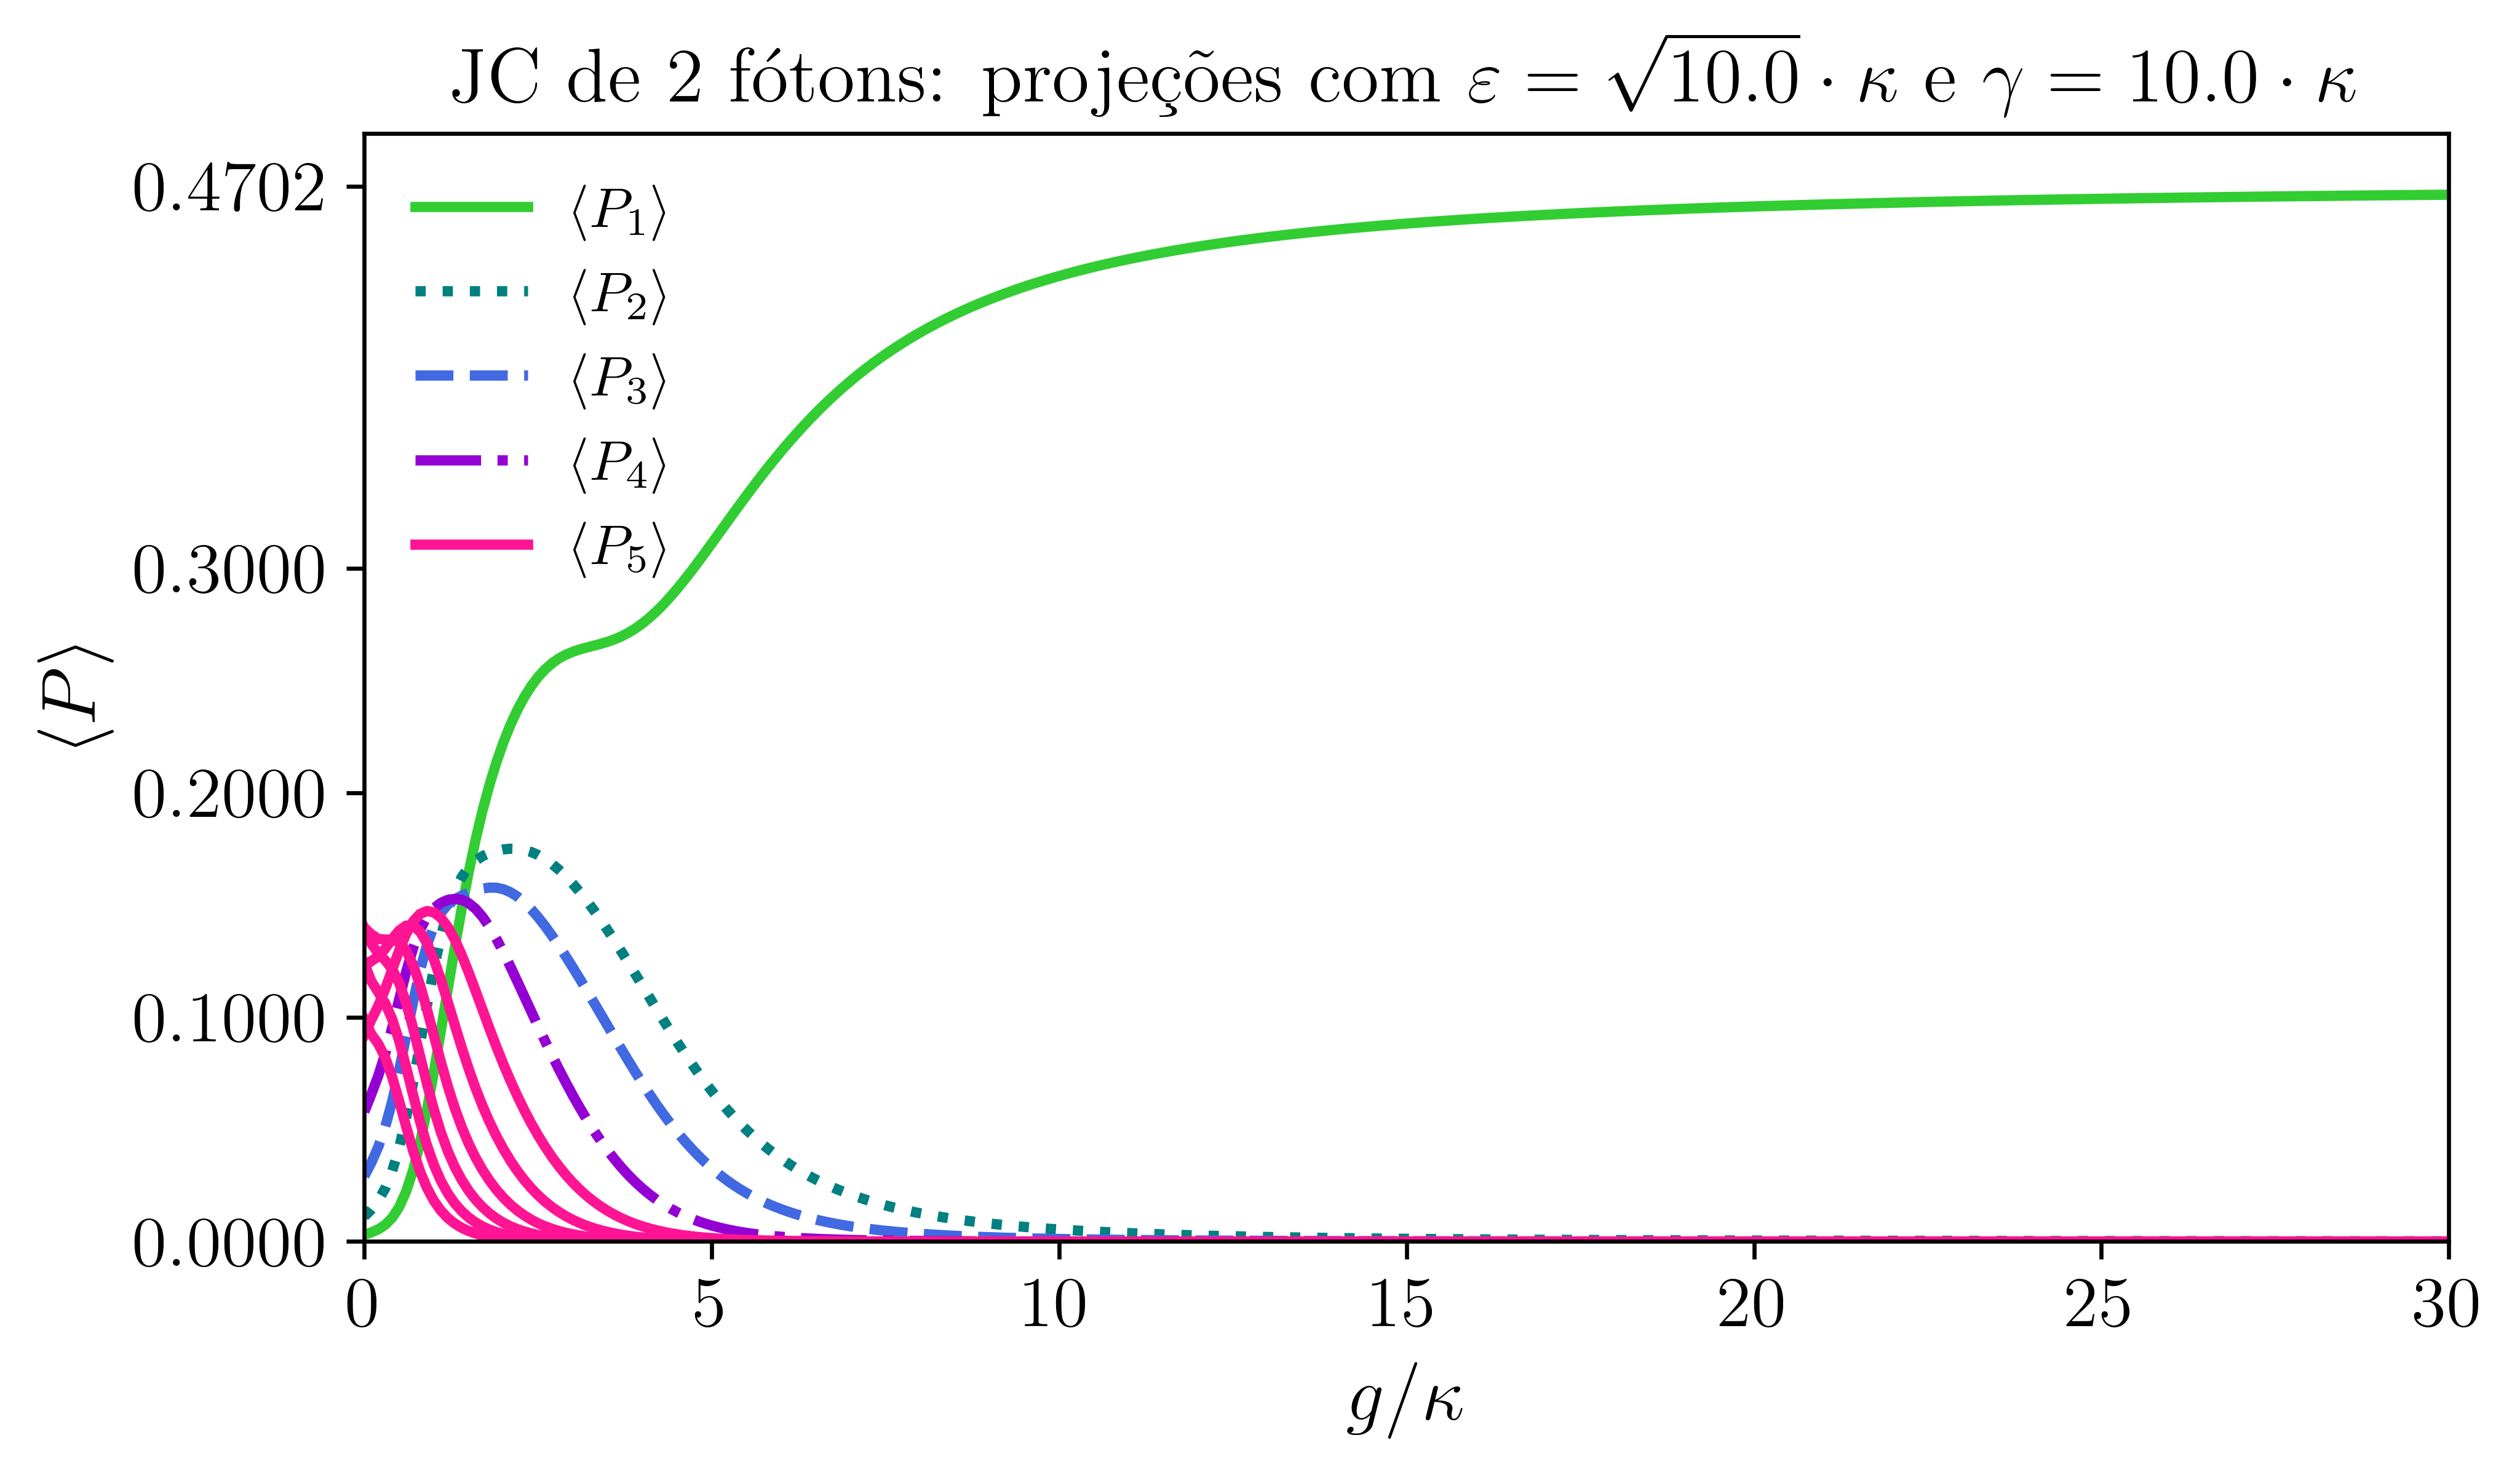

In [42]:
#Plot: projections
fig= plt.figure(figsize=(2*3.54,1.2*3.54), dpi=600, tight_layout=True)
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0,0])

ax1.plot(g_list, P_1_list ,color='limegreen',linestyle='solid',lw=2)
ax1.plot(g_list, P_2_list ,color='teal',linestyle='dotted',lw=2)
ax1.plot(g_list, P_3_list ,color='royalblue',linestyle='dashed',lw=2)


ax1.set_xlabel(r'$g/\kappa$')
ax1.set_ylabel(r'$\langle P \rangle$')
#ax2.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax1.set_xlim([0,30.0])
ax1.set_ylim([0.0,1.05*max(P_1_list)])
ax1.set_yticks([0.0,0.1,0.2,0.3,max(P_1_list)])
ax1.legend([r'$\langle P_{1} \rangle$',r'$\langle P_{2} \rangle$',r'$\langle P_{3} \rangle$',r'$\langle P_{4} \rangle$',r'$\langle P_{5} \rangle$'],frameon=False,loc=2)

plt.title(r'JC de 2 fótons: projeções com $\varepsilon=\sqrt{10.0}\cdot\kappa$ e $\gamma = 10.0\cdot\kappa$', fontsize=15)
fig.savefig('EIT_fockprojections_ep001.png', format='png', dpi=600)
plt.show()

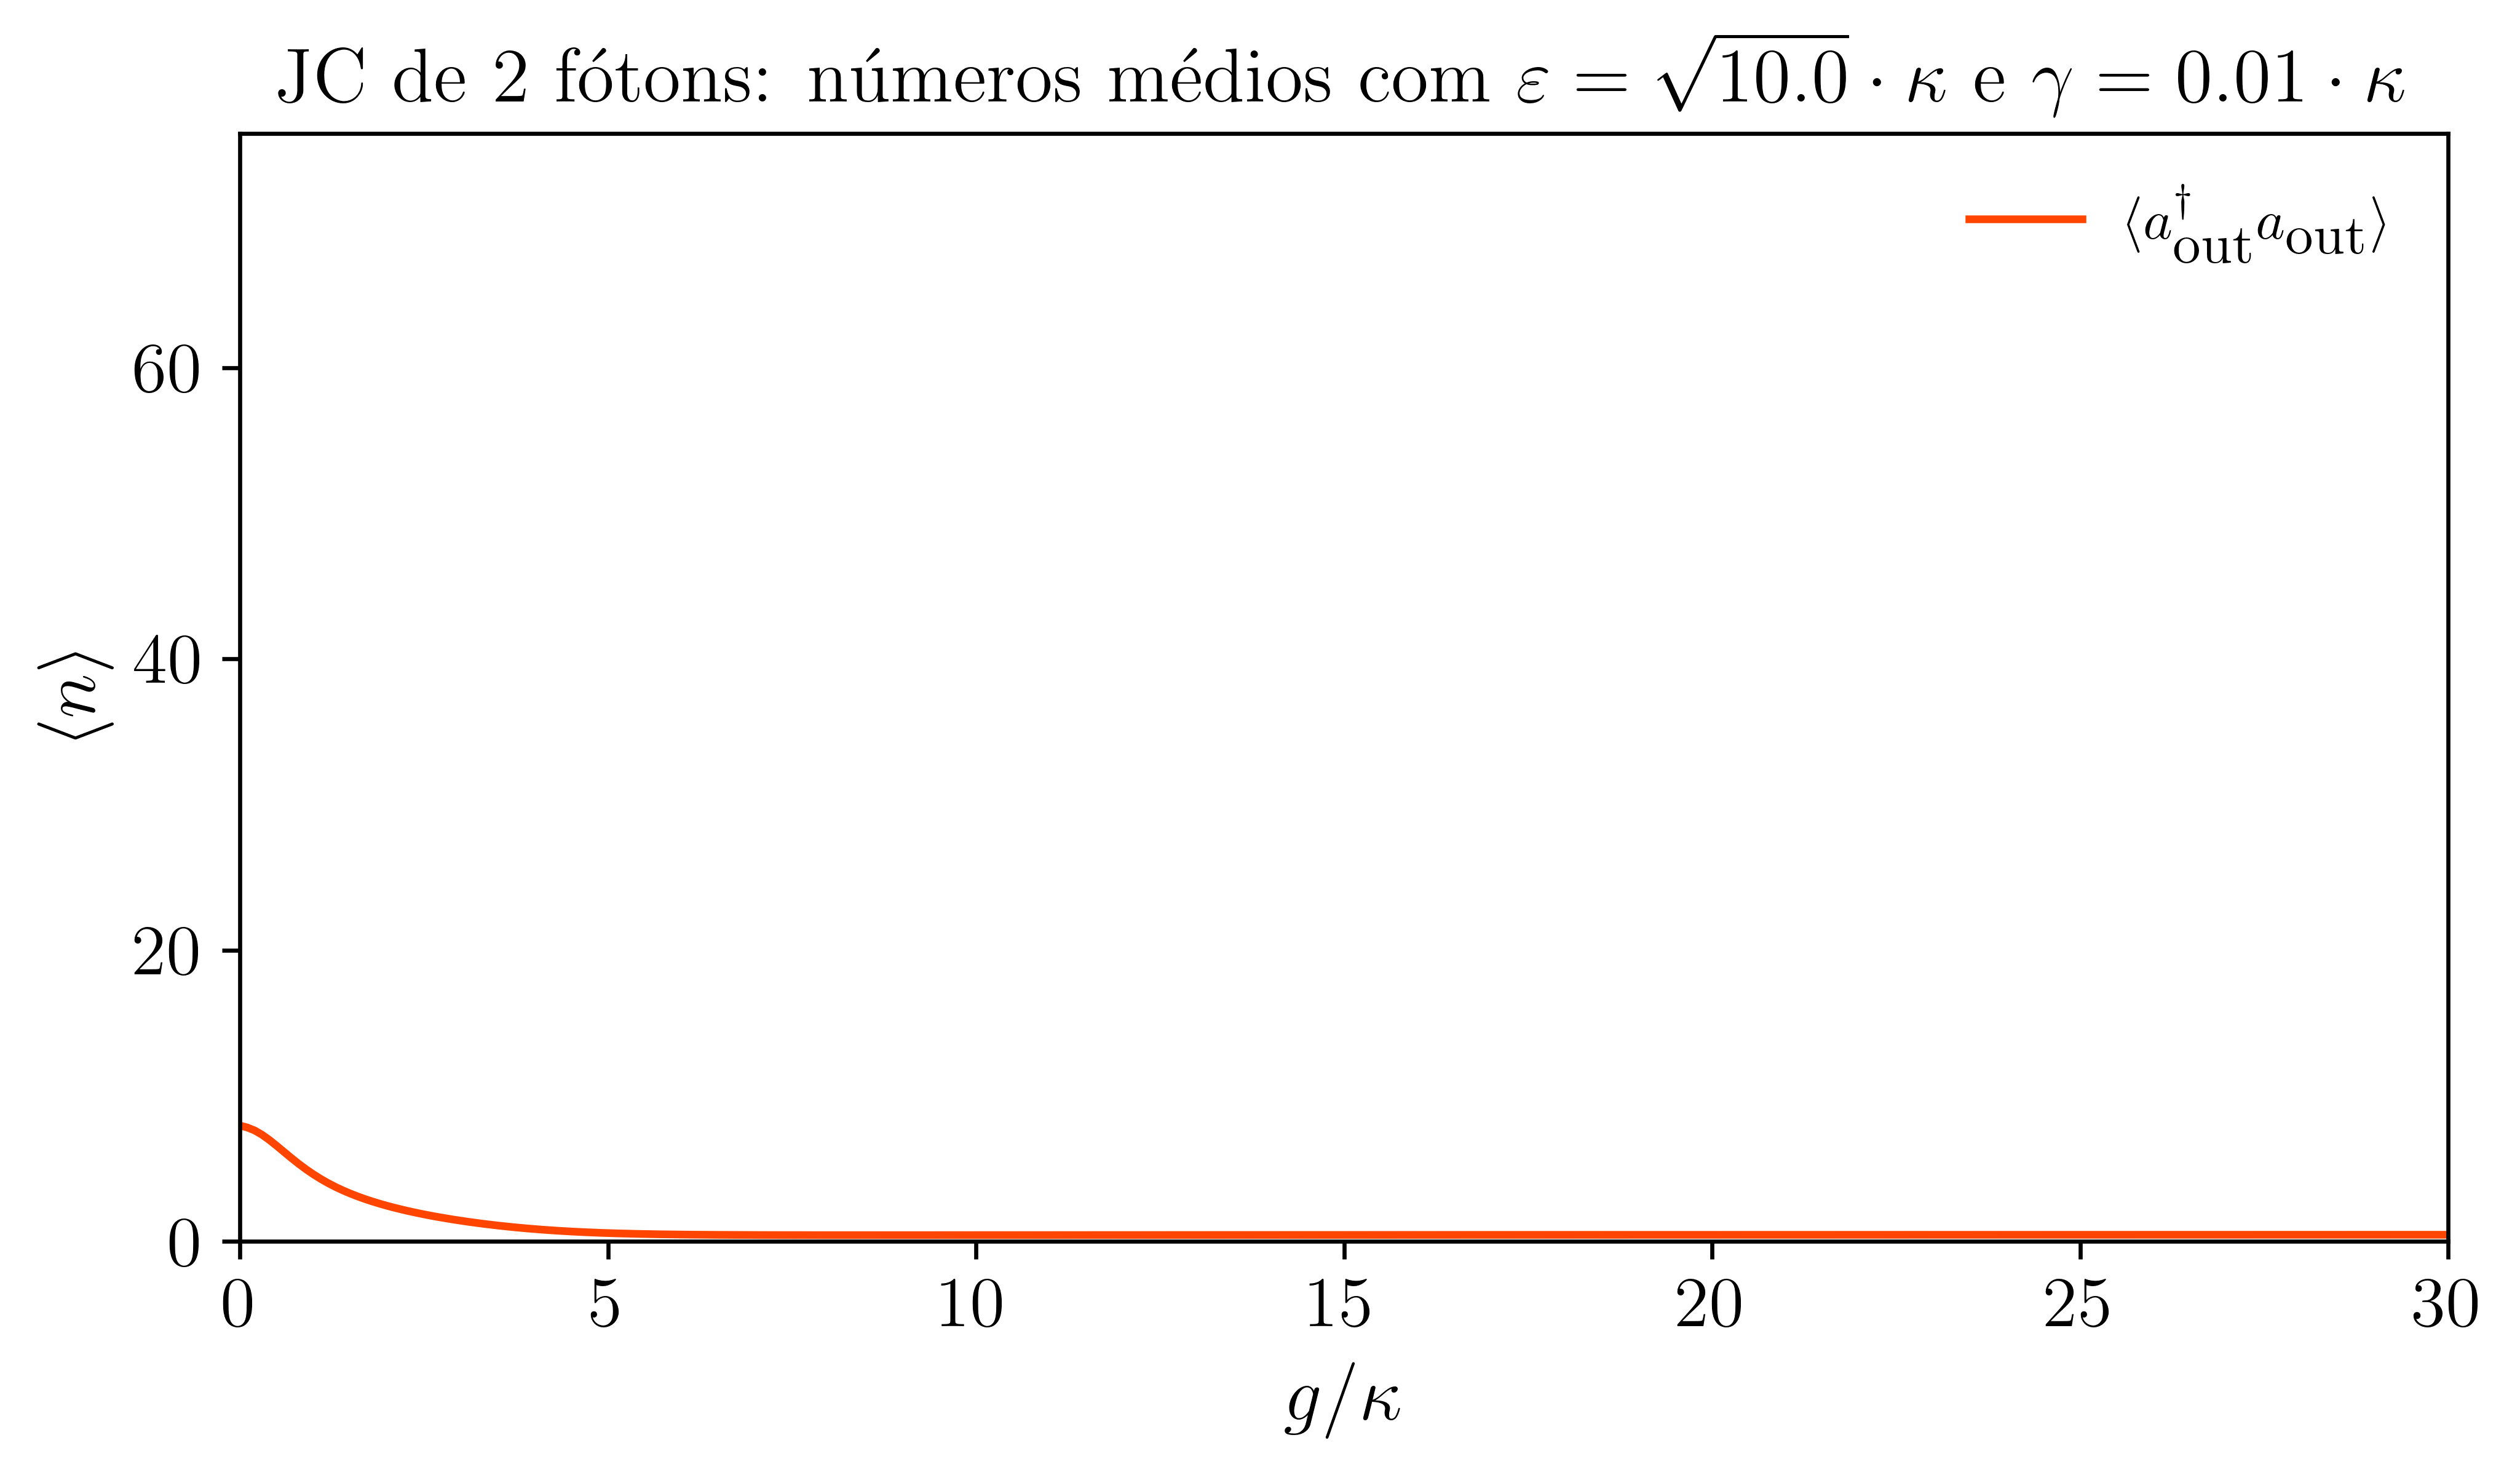

In [43]:
#Plot: mean numbers
fig = plt.figure(figsize=(2*3.54,1.2*3.54), dpi=600, tight_layout=True)
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0,0])

ax1.plot(g_list, np_list ,color='orangered',linestyle='solid')
#ax1.plot(g_list, n2_list ,color='sienna',linestyle='dotted',)
#ax1.plot(g_list, na_list ,color='olivedrab',linestyle='dashed')

ax1.set_xlabel(r'$g/\kappa$')
ax1.set_ylabel(r'$\langle n \rangle$')
#ax2.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax1.set_xlim([0,30.0])
ax1.set_ylim([0.0,1.2*max(n2_list)])
ax1.legend([r'$\langle a^\dagger_{\textrm{out}}a_{\textrm{out}}  \rangle$',r'$\langle a^\dagger_{\textrm{out}}a^\dagger_{\textrm{out}} a_{\textrm{out}}a_{\textrm{out}}\rangle$',r'$\langle \sigma_+ \sigma_- \rangle$'],frameon=False,loc=1)
plt.title(r'JC de 2 fótons: números médios com $\varepsilon=\sqrt{10.0}\cdot\kappa$ e $\gamma = 0.01\cdot\kappa$', fontsize=15)
fig.savefig('meannumber_ep10_gamma001.png', format='png', dpi=600)
plt.show()

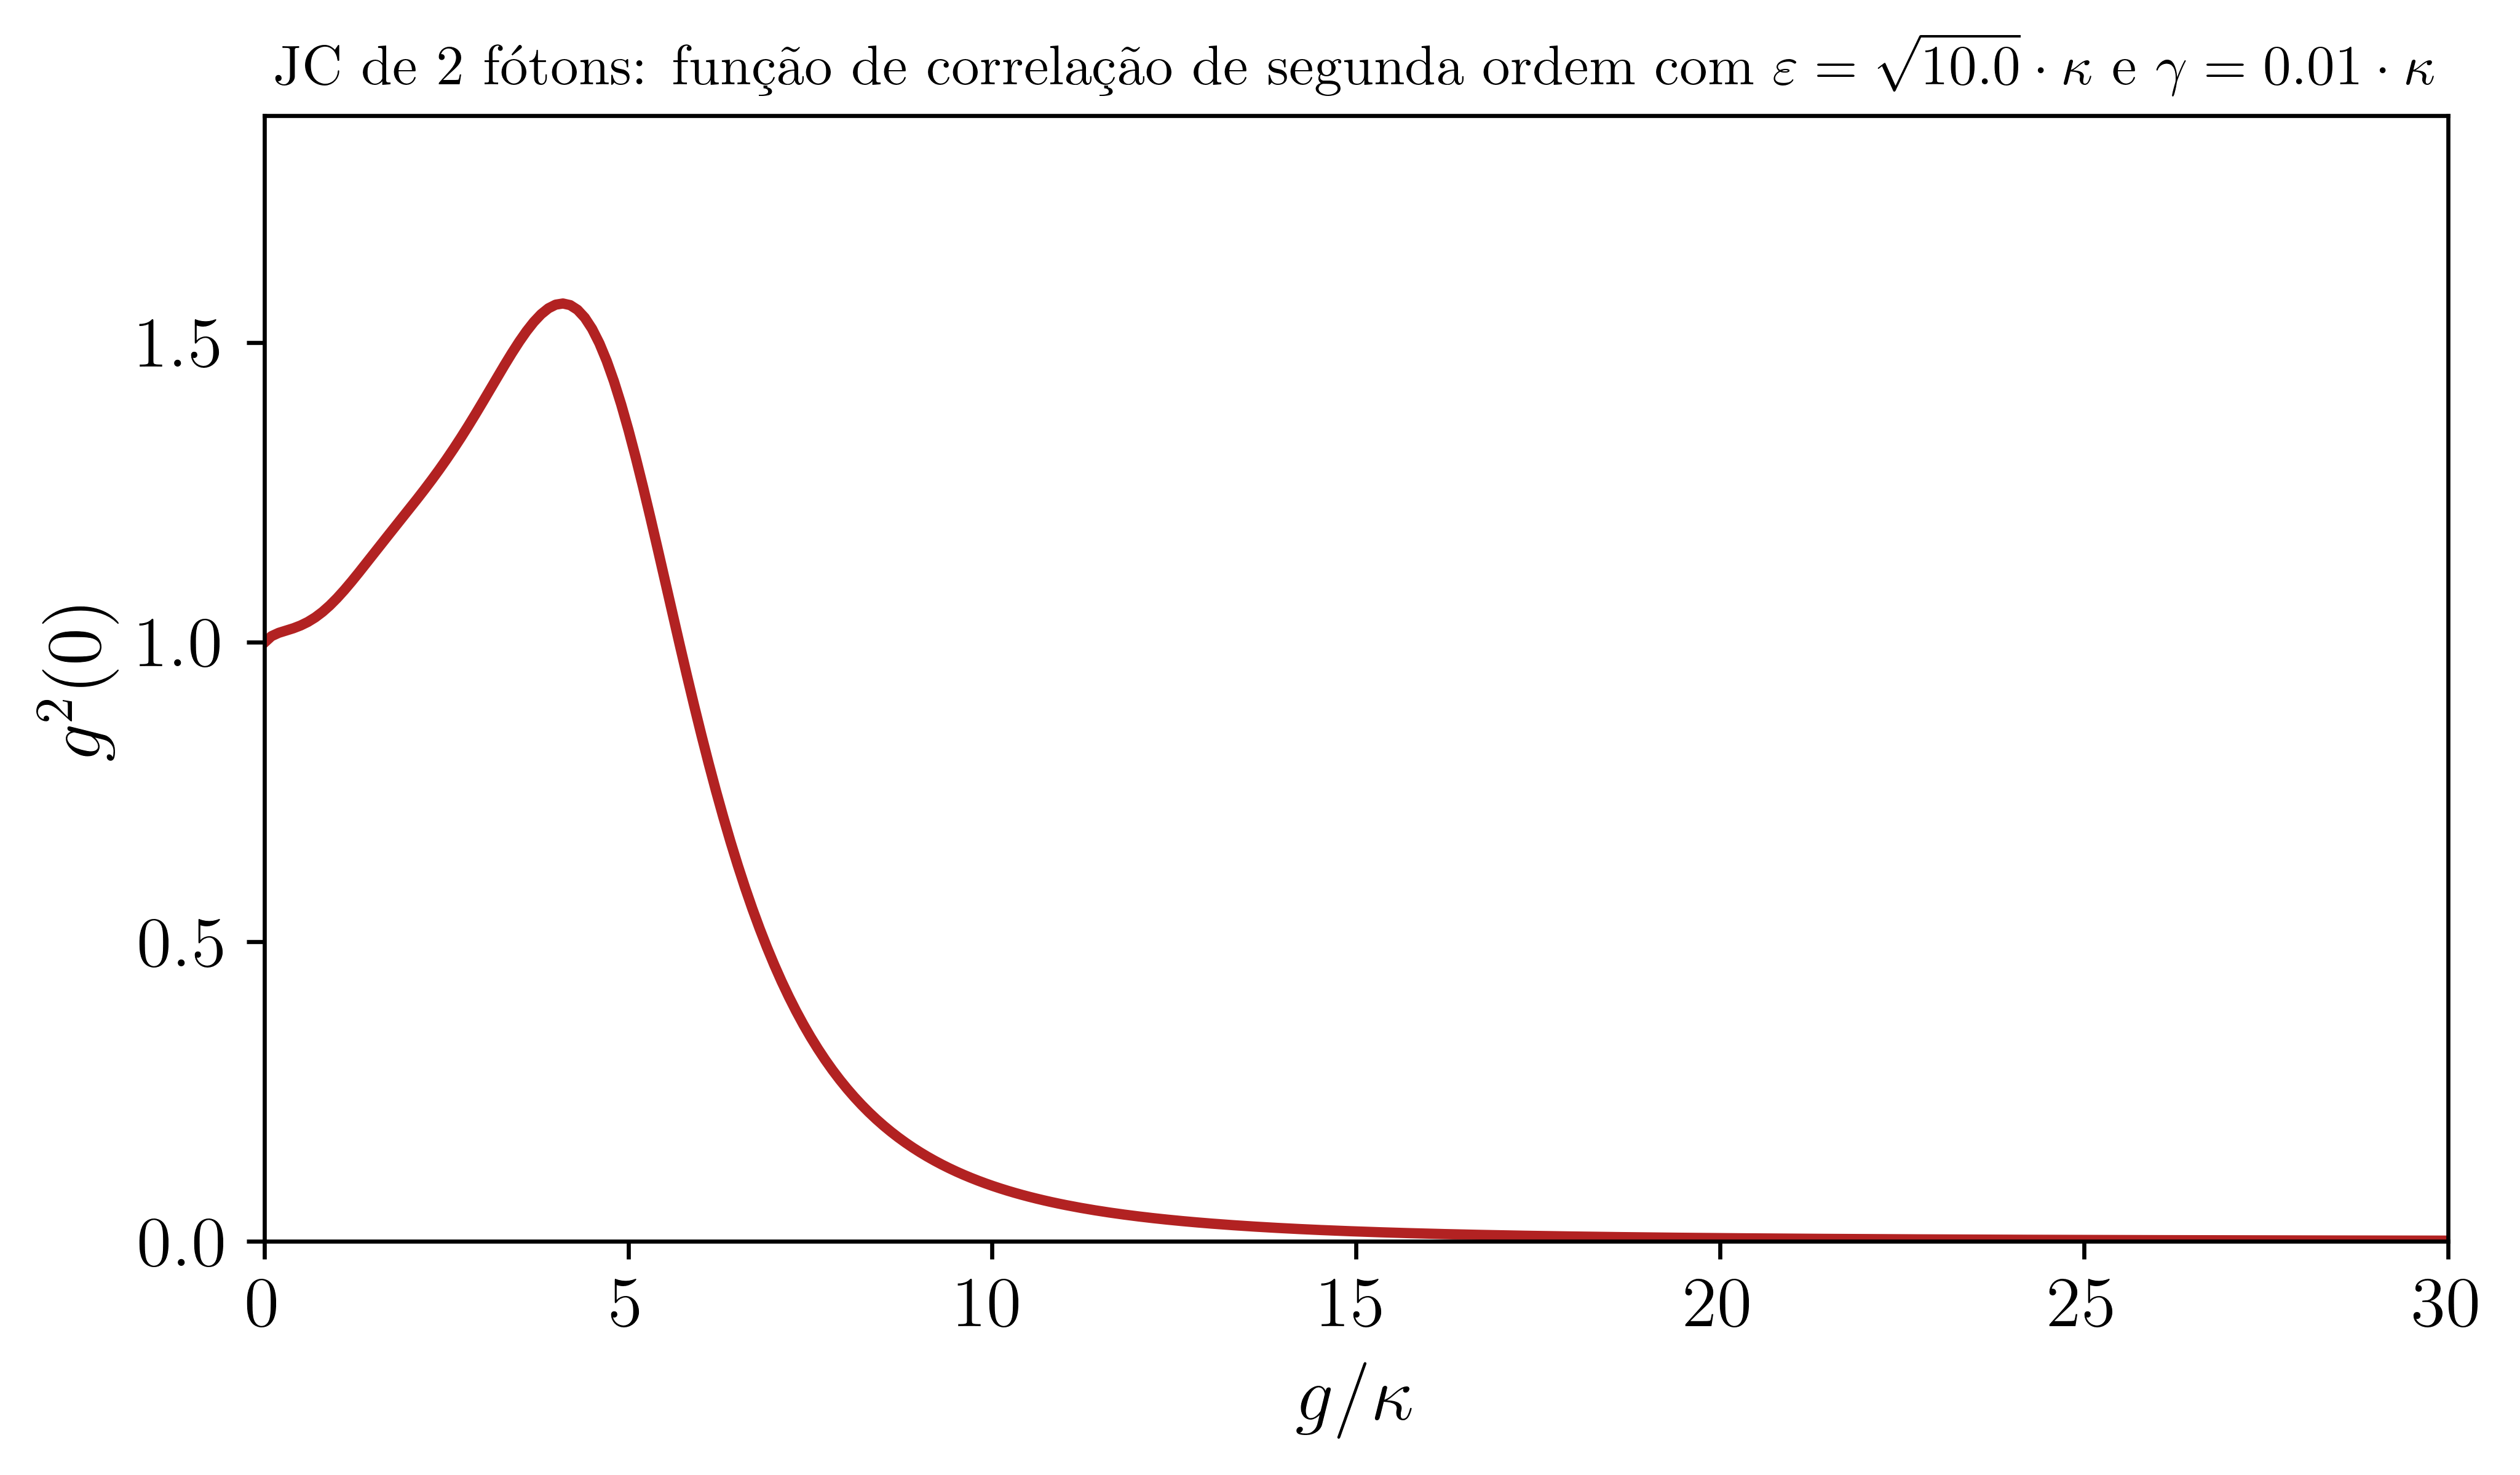

In [44]:
#Plot: second order correlations
fig = plt.figure(figsize=(2*3.54,1.2*3.54), dpi=600, tight_layout=True)
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0,0])

ax1.plot(g_list, g20_list ,color='firebrick',linestyle='solid',lw=2)

ax1.set_xlabel(r'$g/\kappa$')
ax1.set_ylabel(r'$g^{2}(0)$')
#ax2.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax1.set_xlim([0,30.0])
ax1.set_ylim([0.0,1.2*max(g20_list)])

plt.title(r'JC de 2 fótons: função de correlação de segunda ordem com $\varepsilon=\sqrt{10.0}\cdot\kappa$ e $\gamma = 0.01\cdot\kappa$', fontsize=11)
fig.savefig('g20_ep10_gamma001.png', format='png', dpi=600)
plt.show()

In [ ]:
#Plot: eigenstates projections
fig = plt.figure(figsize=(2*3.54,1.2*3.54), dpi=600, tight_layout=True)
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0,0])

ax1.plot(g_list, E0_list ,color='gold',linestyle='dashed',lw=2)
ax1.plot(g_list, E1_list ,color='darkolivegreen',linestyle='dotted',lw=2)
ax1.plot(g_list, E2p_list ,color='darkolivegreen',linestyle='solid',lw=2)
ax1.plot(g_list, E2m_list ,color='lightseagreen',linestyle='dashdot',lw=2)
ax1.plot(g_list, E3p_list ,color='dodgerblue',linestyle='solid',lw=2)
ax1.plot(g_list, E3m_list ,color='violet',linestyle='dashdot',lw=2)
ax1.set_xlabel(r'$g/\kappa$')
ax1.set_ylabel(r'$\langle \textrm{Autoestados} \rangle$')
#ax2.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax1.set_xlim([0,10.0])
ax1.set_ylim([0.0,1.2*max(E0_list)])
ax1.set_yticks([0.0,0.2,0.4,max(E0_list)])
ax1.legend([r'$|0,g\rangle$',
            r'$|1,g\rangle$',
            r'$|2,+\rangle = \frac{1}{\sqrt{2}}\left(|2,g\rangle + |0,e\rangle\right)$',
            r'$|2,-\rangle = \frac{1}{\sqrt{2}}\left(|2,g\rangle - |0,e\rangle\right)$',
            r'$|3,+\rangle = \frac{1}{\sqrt{2}}\left(|3,g\rangle + |1,e\rangle\right)$',
            r'$|3,-\rangle = \frac{1}{\sqrt{2}}\left(|3,g\rangle - |1,e\rangle\right)$'],frameon=False,loc=1)




plt.title(r'JC de 2 fótons: projeções dos autoestados com $\varepsilon=\sqrt{10.0}\cdot\kappa$ e $\gamma = 0.01\cdot\kappa$', fontsize=14)
fig.savefig('eigenstatesprojections_ep10_gamma001.png', format='png', dpi=600)
plt.show()

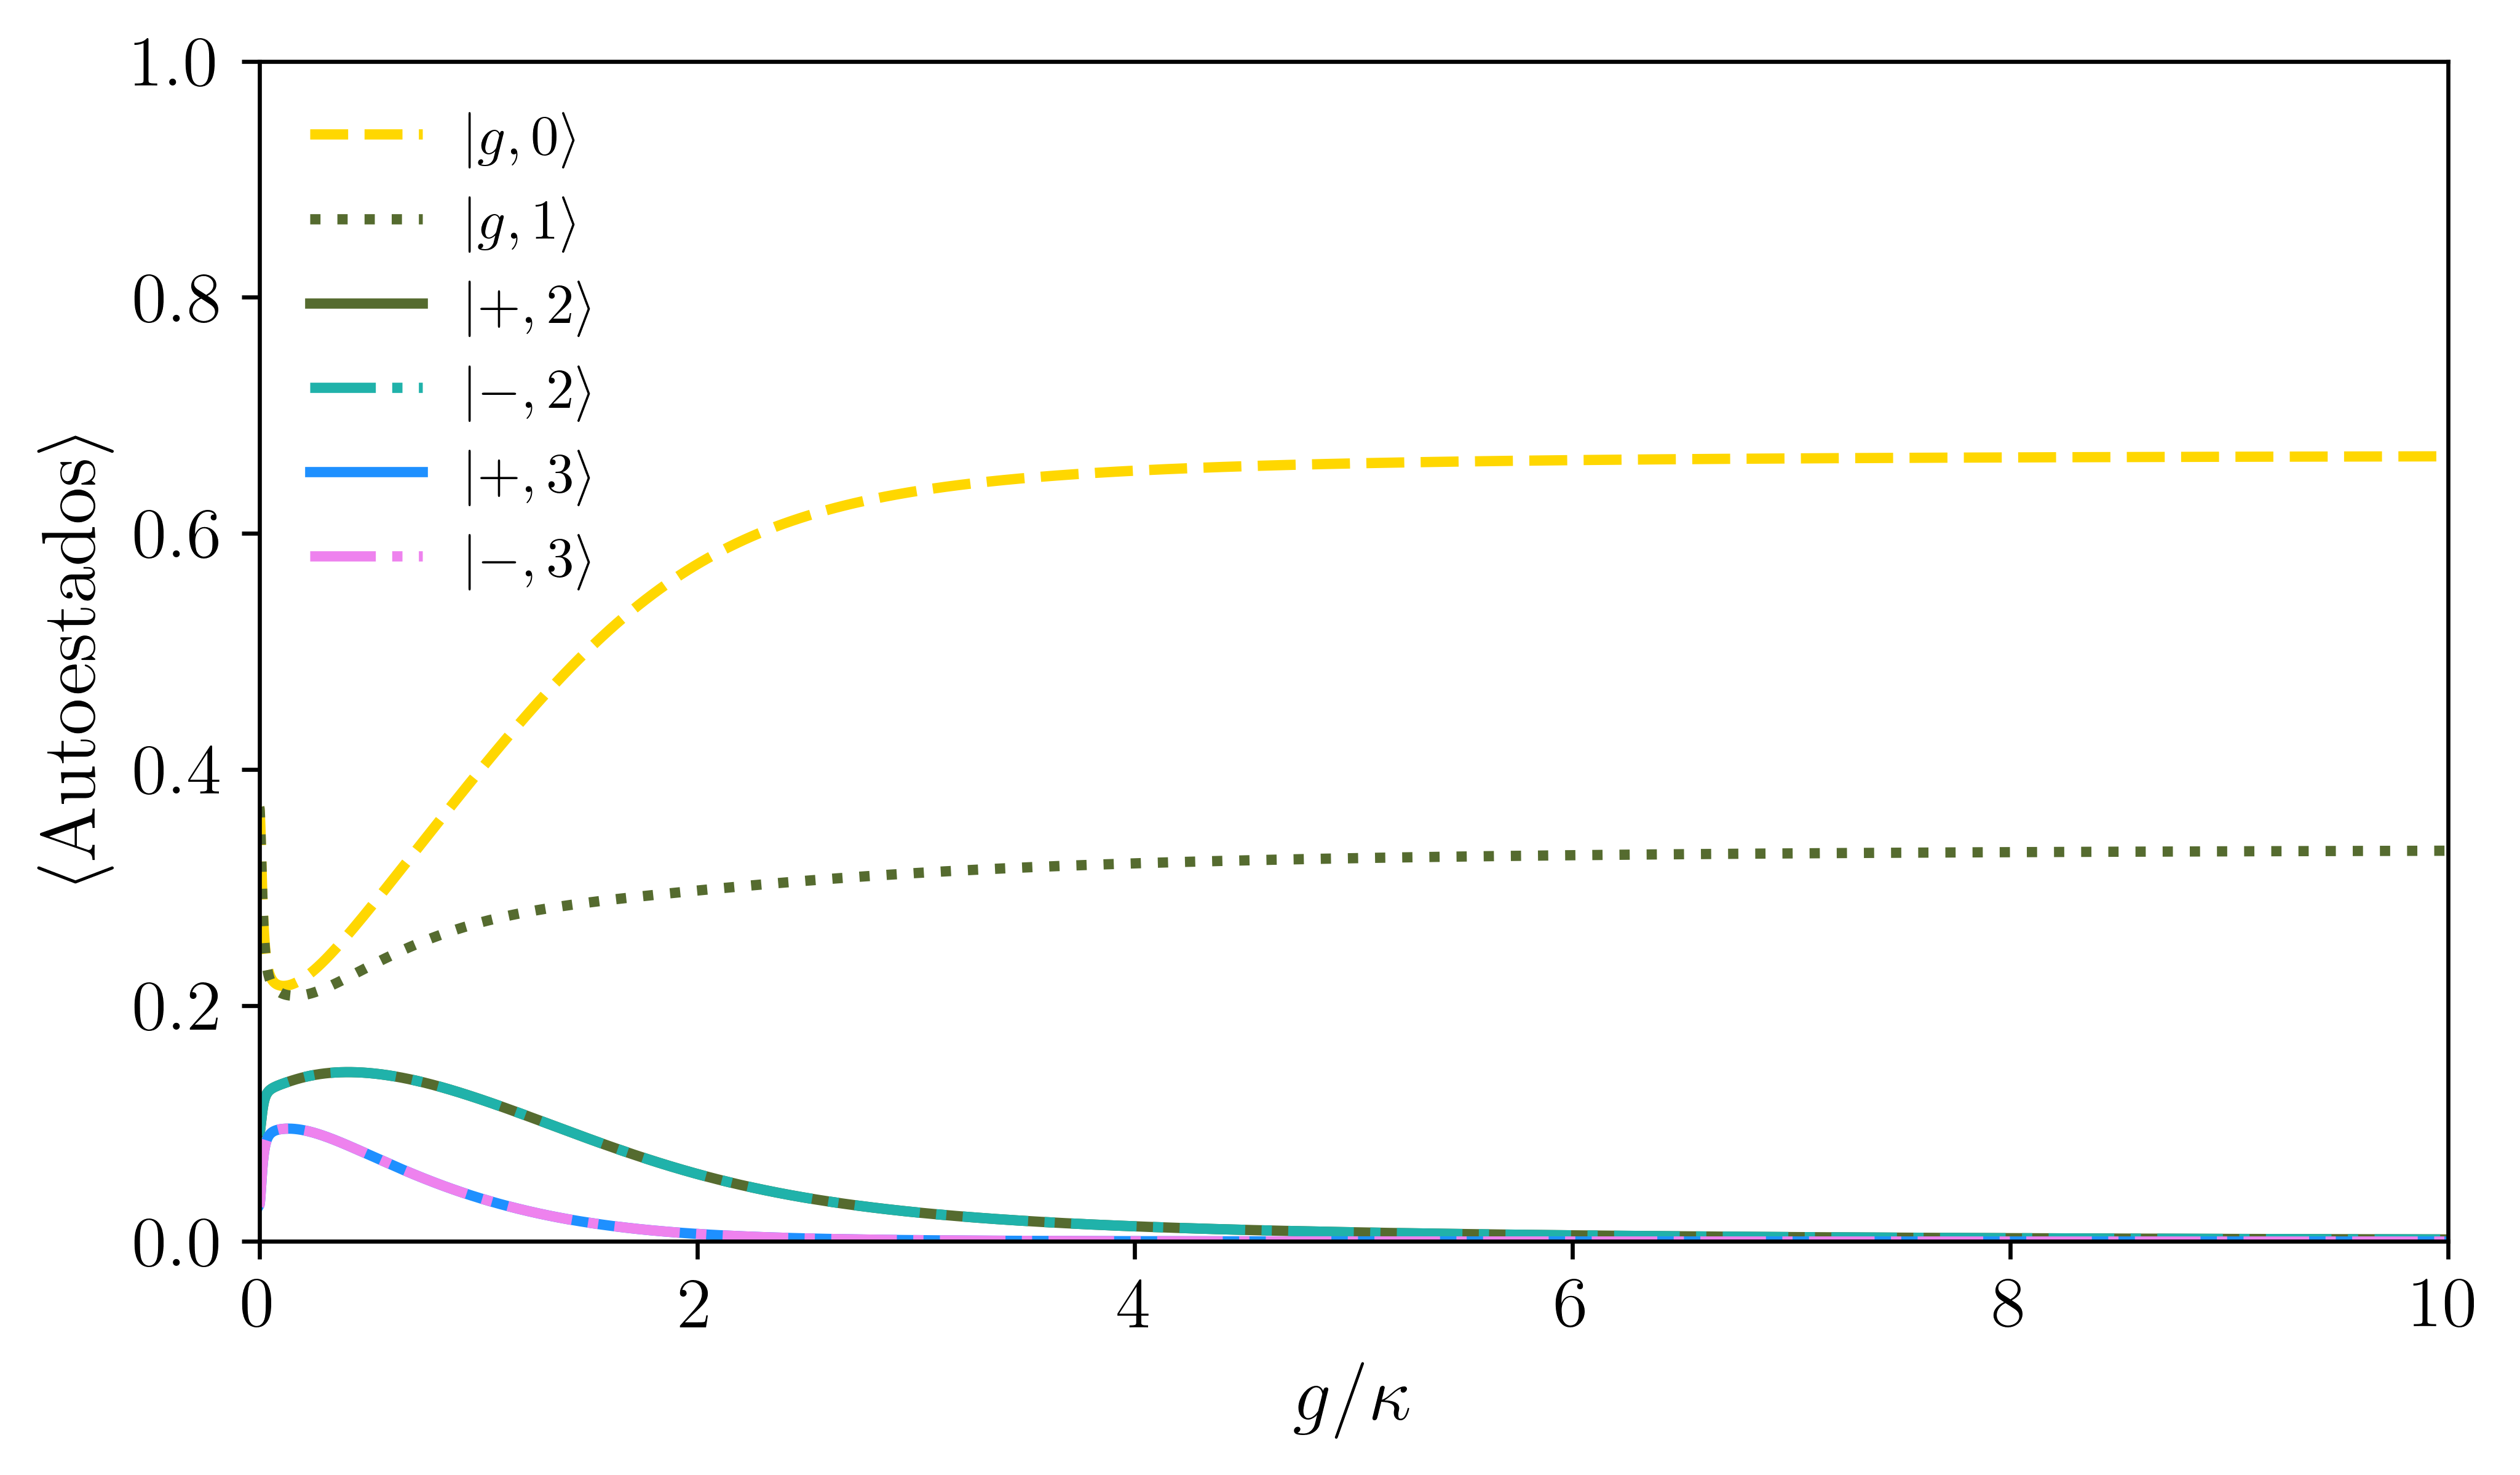

In [30]:
#Plot: eigenstates projections - para TCC2
fig = plt.figure(figsize=(2*3.54,1.2*3.54), dpi=600, tight_layout=True)
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0,0])

ax1.plot(g_list, E0_list ,color='gold',linestyle='dashed',lw=2)
ax1.plot(g_list, E1_list ,color='darkolivegreen',linestyle='dotted',lw=2)
ax1.plot(g_list, E2p_list ,color='darkolivegreen',linestyle='solid',lw=2)
ax1.plot(g_list, E2m_list ,color='lightseagreen',linestyle='dashdot',lw=2)
ax1.plot(g_list, E3p_list ,color='dodgerblue',linestyle='solid',lw=2)
ax1.plot(g_list, E3m_list ,color='violet',linestyle='dashdot',lw=2)
ax1.set_xlabel(r'$g/\kappa$')
ax1.set_ylabel(r'$\langle \textrm{Autoestados} \rangle$')
#ax2.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax1.set_xlim([0,10.0])
#ax1.set_ylim([0.0,1.2*max(E0_list)])
ax1.set_ylim([0.0,1.0])
#ax1.set_yticks([0.0,0.2,0.4,max(E0_list)])
ax1.legend([r'$|g,0\rangle$',
            r'$|g,1\rangle$',
            r'$|+, 2\rangle$',
            r'$|-, 2\rangle$',
            r'$|+, 3\rangle$',
            r'$|-, 3\rangle$'],frameon=False,loc=2)


#plt.title(r'JC de 2 fótons: projeções dos autoestados com $\varepsilon=\sqrt{10.0}\cdot\kappa$ e $\gamma = 0.01\cdot\kappa$', fontsize=14)
fig.savefig('eigenstatesprojections_ep1.png', format='png', dpi=600)
plt.show()